In [1]:
import numpy as np
from PIL import Image

from functools import partial
from numbers import Complex
from typing import Callable

import matplotlib.pyplot as plt

In [2]:
c: Complex = -0.7 + 0.27015j

def Q(z: Complex, c: Complex) -> Complex:
    return z ** (2) + c

In [3]:
min_coordinate = -.25 - .25j
max_coordinate = .25 + .25j
iterations_count = 256

In [4]:
img_path = r"frog.jpeg"

# Julia Set

Code shamelessely stolen from [here](https://rosettacode.org/wiki/Julia_set#Vectorized).

In [5]:
def julia_set(mapping: Callable[[Complex], Complex],
              *,
              min_coordinate: Complex,
              max_coordinate: Complex,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    """
    As described in https://en.wikipedia.org/wiki/Julia_set
    :param mapping: function defining Julia set
    :param min_coordinate: bottom-left complex plane coordinate
    :param max_coordinate: upper-right complex plane coordinate
    :param height: pixels in vertical axis
    :param width: pixels in horizontal axis
    :param iterations_count: number of iterations
    :param threshold: if the magnitude of z becomes greater
    than the threshold we assume that it will diverge to infinity
    :return: 2D pixels array of intensities
    """
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j,
                      min_coordinate.real: max_coordinate.real: width * 1j]
    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)  # indexes of pixels that have not escaped
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else:
        iterations[live] = iterations_count

    return iterations.reshape((height, width))

In [6]:
mapping = partial(Q, c=c)
image = julia_set(mapping,
                  min_coordinate=min_coordinate,
                  max_coordinate=max_coordinate,
                  width=108*3,
                  height=108,
                  iterations_count=iterations_count)

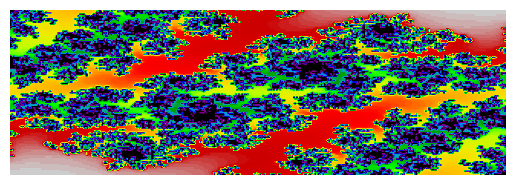

In [7]:
plt.axis('off')
plt.imshow(image,
           cmap='nipy_spectral_r',
           origin='lower')
plt.show()

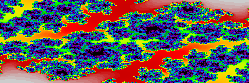

(108, 324, 3)


In [8]:
# Convert plot to numpy array
fig, ax = plt.subplots(figsize=(image.shape[1], image.shape[0]), dpi=1)
ax.axis('off')
ax.imshow(image, cmap='nipy_spectral_r', origin='lower')
fig.canvas.draw()
image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
plt.show()
print(image_array.shape)

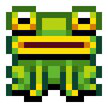

In [9]:
# load the image and convert into numpy array
img = Image.open(img_path)
frog = np.asarray(img)
img
# img.resize((128,128), Image.Resampling.LANCZOS)

# Encryption

## Encryption

In [10]:
mapping_e = partial(Q, c=c)

In [11]:
height, width, _ = frog.shape
julia = julia_set(
    mapping_e, 
    min_coordinate=min_coordinate, 
    max_coordinate=max_coordinate, 
    width=width*3, 
    height=height,
    iterations_count=iterations_count
).flatten()

In [12]:
encrypted_image = (
    (
        frog.flatten() + (julia % 256).astype(np.uint8)
    ) % 256
)[np.argsort(julia)].reshape((height, width, 3))

## Decryption

(i + j) % x = r
then,
i = (r - j) % x

In [13]:
mapping_d = partial(Q, c=c)

In [14]:
height, width, _ = encrypted_image.shape
julia = julia_set(
    mapping_d,
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    width=width*3,
    height=height,
    iterations_count=iterations_count
).flatten()

In [15]:
decrypted_image = (
    (
        encrypted_image.flatten()[np.argsort(np.argsort(julia))] - 
        (julia % 256).astype(np.uint8)
    ) % 256       
).reshape((height, width, 3))

# Images

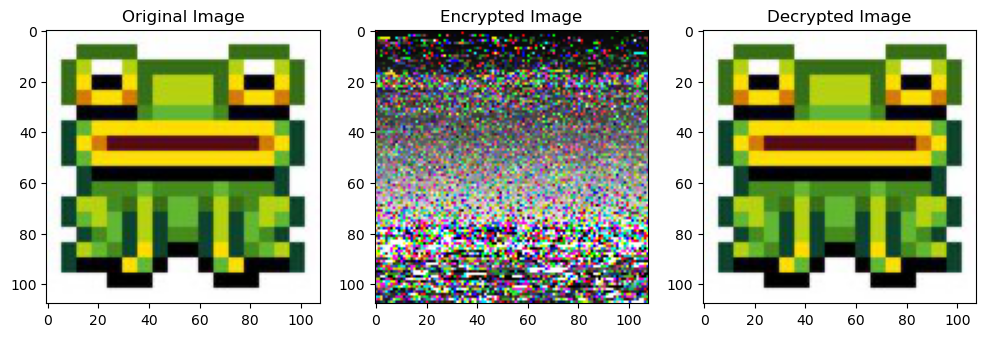

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(frog)

plt.subplot(1, 3, 2)
plt.title("Encrypted Image")
plt.imshow(encrypted_image)

plt.subplot(1, 3, 3)
plt.title("Decrypted Image")
plt.imshow(decrypted_image)
plt.show()

# References
1. [Julia set](https://rosettacode.org/wiki/Julia_set#Python)
2. [Convert PIL image to numpy array](https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/)
3. [Convert Matplotlib plot to numpy array](https://www.geeksforgeeks.org/save-plot-to-numpy-array-using-matplotlib/)